In [63]:
import pandas as pd
import numpy as np
import os
from transformers import RobertaTokenizerFast
from sklearn import metrics
import onnxruntime
import matplotlib.pyplot as plt

Функция для создания DataFrame

In [38]:
def make_df(path):
    data_dict = dict(text = [],
                     y_score_true = [])
    for rootdir, dirs, files in os.walk(path):
        for file in files:
            with open(os.path.join(rootdir, file)) as f:
                try:
                    text = " ".join(f.readlines())
                    text = text.replace(r"<br />", "")
                    score = float(file[:-4].split("_")[-1])
                    data_dict["text"].append(text)
                    data_dict["y_score_true"].append(score)
                except:
                    print("Ошибка чтения файла", file)
    frame = pd.DataFrame(data_dict)
    return frame

Генеративная функция

In [30]:
def get_predict_function(path_to_onnx):
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    ort_session = onnxruntime.InferenceSession(path_to_onnx)
    input_names = [i.name for i in ort_session.get_inputs()]
    def predict_function(text):
        input_sample_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='np',
        )
        ort_inputs = {input_names[0]: np.int64(input_sample_dict["input_ids"]),
                      input_names[1]: np.int64(input_sample_dict["attention_mask"]),
                      input_names[2]: np.int64(input_sample_dict["token_type_ids"]),}
        return ort_session.run(None, ort_inputs)[0][0]
    return predict_function

Генерация функции для предсказания

In [33]:
predict_function = get_predict_function("ROBERTA_model.onnx")

Чтение данных

In [ ]:
test_df = make_df(r"aclImdb\test")

Вычисление результатов модели

In [ ]:
test_df["y_score_model"] = test_df["text"].apply(predict_function)

Сохранение полученного DataFrame

In [ ]:
test_df.to_csv("test_df.csv", index=False)

In [55]:
test_df = pd.read_csv("test_df.csv")

Добавление меток классов

In [56]:
test_df["y_label_true"] = test_df["y_score_true"] > 5.5
test_df["y_label_model"] = test_df["y_score_model"] > 5.5

In [57]:
test_df

,text,y_score_true,y_score_model,y_label_true,y_label_model
0,Once again Mr. Costner has dragged out a movie...,2.0,2.643263,False,False
1,This is an example of why the majority of acti...,4.0,4.058494,False,False
2,"First of all I hate those moronic rappers, who...",1.0,1.269353,False,False
3,Not even the Beatles could write songs everyon...,3.0,3.246474,False,False
4,Brass pictures (movies is not a fitting word f...,3.0,2.357594,False,False
...,...,...,...,...,...
24988,I was extraordinarily impressed by this film. ...,8.0,10.017828,True,True
24989,"Although I'm not a golf fan, I attended a snea...",10.0,9.706835,True,True
24990,"From the start of ""The Edge Of Love"", the view...",8.0,8.257510,True,True
24991,"This movie, with all its complexity and subtle...",10.0,9.938754,True,True


Вычисление метрик

In [58]:
metrics.r2_score(test_df["y_score_true"], test_df["y_score_model"])

0.8448122232932485

In [59]:
metrics.mean_absolute_error(test_df["y_score_true"], test_df["y_score_model"])

0.847241753118073

In [61]:
metrics.accuracy_score(test_df["y_label_true"], test_df["y_label_model"])

0.9552274636898331

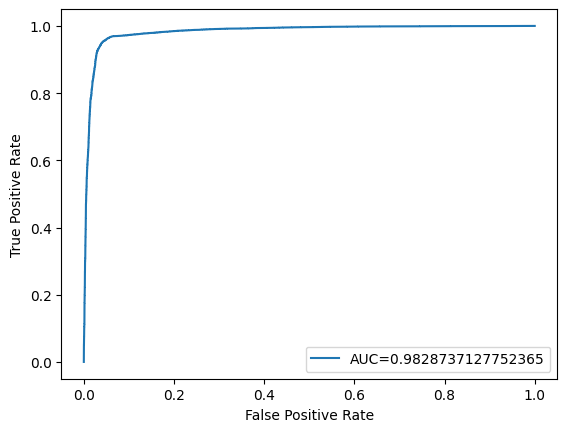

In [64]:
fpr, tpr, _ = metrics.roc_curve(test_df["y_label_true"], test_df["y_score_model"])
auc = metrics.roc_auc_score(test_df["y_label_true"], test_df["y_score_model"])
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()